### Load Library

In [1]:
!pip install torch transformers datasets scikit-learn tqdm peft --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsf

In [2]:
!pip uninstall fsspec -y --quiet
!pip install fsspec==2023.9.2 --quiet
!pip install datasets==2.14.6 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.2 requires dill>=0.3.8, but you have dill 0

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer,get_linear_schedule_with_warmup, T5EncoderModel
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-27 04:33:57.470811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748320437.697669      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748320437.767098      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Dataset Loader

In [5]:
dataset = load_dataset("fancyzhx/amazon_polarity")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [6]:
class AmazonPolarityDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['content']
        label = item['label']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
train_subset = dataset['train'].select(range(100000))  # Use 100k samples
test_subset = dataset['test'].select(range(20000))    # Use 20k samples


train_dataset = AmazonPolarityDataset(train_subset, tokenizer)
test_dataset = AmazonPolarityDataset(test_subset, tokenizer)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

### Model

In [9]:
class T5ClassifierWithSFT(nn.Module):
    def __init__(self, model_name='t5-small', num_classes=2):
        super().__init__()

        # Load T5 encoder model (more efficient for classification tasks)
        self.t5 = T5EncoderModel.from_pretrained(model_name)


        # Classification head (similar to BERT example)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.t5.config.d_model, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.logsm = nn.LogSoftmax(dim=1)

        # Print trainable parameters
        self.print_trainable_parameters()

    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask)

        # Get the last hidden states
        last_hidden_states = outputs.last_hidden_state

        # Apply mean pooling (taking the mean of all tokens)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_pooled = sum_embeddings / sum_mask

        # Pass through classifier
        x = self.dropout(mean_pooled)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.logsm(x)
    def print_trainable_parameters(self):
        """Print the number of trainable parameters"""
        trainable_params = 0
        all_param = 0

        for param in self.parameters():
            all_param += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()

        print(f"Trainable params: {trainable_params:,} || All params: {all_param:,} || Trainable%: {100 * trainable_params / all_param:.2f}%")

In [10]:
model = T5ClassifierWithSFT()
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Trainable params: 35,594,498 || All params: 35,594,498 || Trainable%: 100.00%


T5ClassifierWithSFT(
  (t5): T5EncoderModel(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_features=2048, 

In [11]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = nn.NLLLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.NLLLoss()(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, predictions, actual_labels

In [13]:
num_epochs = 5
learning_rate = 3e-4

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

In [14]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()


Epoch 1/5


Evaluating: 100%|██████████| 625/625 [01:30<00:00,  6.94it/s]


Train Loss: 0.2582, Train Acc: 0.8888
Val Loss: 0.1794, Val Acc: 0.9335

Epoch 2/5


Evaluating: 100%|██████████| 625/625 [01:29<00:00,  6.94it/s]


Train Loss: 0.1552, Train Acc: 0.9426
Val Loss: 0.1746, Val Acc: 0.9387

Epoch 3/5


Evaluating: 100%|██████████| 625/625 [01:30<00:00,  6.94it/s]


Train Loss: 0.1116, Train Acc: 0.9602
Val Loss: 0.1882, Val Acc: 0.9376

Epoch 4/5


Evaluating: 100%|██████████| 625/625 [01:30<00:00,  6.94it/s]


Train Loss: 0.0777, Train Acc: 0.9737
Val Loss: 0.2159, Val Acc: 0.9384

Epoch 5/5


Evaluating: 100%|██████████| 625/625 [01:29<00:00,  6.95it/s]


Train Loss: 0.0549, Train Acc: 0.9824
Val Loss: 0.2391, Val Acc: 0.9377


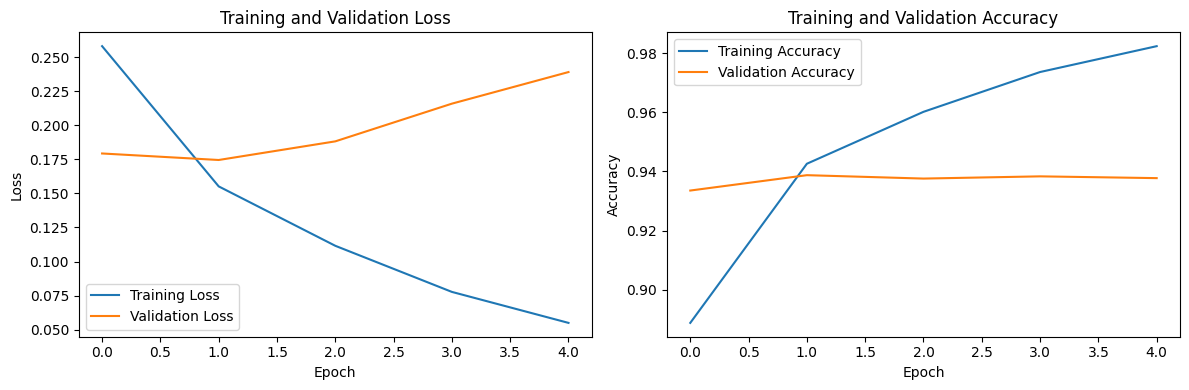

Evaluating: 100%|██████████| 625/625 [01:30<00:00,  6.94it/s]



Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.94      9786
    Positive       0.95      0.93      0.94     10214

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



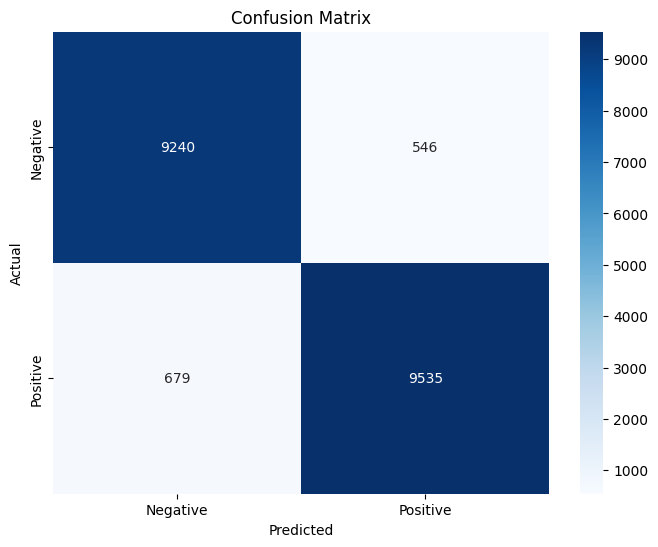

In [15]:
# Training loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc, predictions, actuals = evaluate(model, test_dataloader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Plot training history
plot_training_history(train_losses, train_accs, val_losses, val_accs)

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
_, _, predictions, actuals = evaluate(model, test_dataloader, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(actuals, predictions, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(actuals, predictions, ['Negative', 'Positive'])